# Spectrogram classification 모델 구현
> **2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 만들어보기.**
***
> **1. 데이터 처리와 분류**
> - **라벨 데이터 처리하기**
> - **sklearn의 train_test_split함수를 이용하여 train, test 분리**  
>  
> **2. 학습을 위한 하이퍼파라미터 설정**  
>  
> **3. 데이터셋 구성**  
> - **tf.data.Dataset을 이용**
> - **from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용**  
> - **map과 batch를 이용한 데이터 전처리**  
> - **주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 
> 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.**  
> - **tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 
> spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.**
>  
> **4. 2차원 Spectrogram 데이터를 처리하는 모델 구성**
> - **2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능**  
> - **batchnorm, dropout, dense layer 등을 이용**
> - **12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용**
> - **모델 가중치를 저장하는 checkpoint callback 함수 추가**  
> - **다양한 모델의 실험을 진행해 보시기 바랍니다.**
>  
> **5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력**
> - **loss, accuracy를 그래프로 표현**
>  
> **6. Test dataset을 이용해서 모델의 성능을 평가**
> - **저장한 weight 불러오기**
> - **모델의 예측값과 정답값이 얼마나 일치하는지 확인**
***
### 평가문항
> **1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.  
> -스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.**  
> 
> **2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.  
> -스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.**  
> 
> **3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.  
> -evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.**  


In [1]:
# 필요한 라이브러리 import
import numpy as np
import os
import IPython.display as ipd
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# 1. 데이터 처리와 분류
# 1.1 데이터 셋 가져오기(waveform형태의 데이터)

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
# 1.2 데이터 확인
# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보기)
rand = random.randint(0, len(speech_data["wav_vals"]))

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]

In [3]:
# 라벨처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list 
label_value.append('unknown') # label_value에 unknown 추가
label_value.append('silence') # label_value에 silence 추가

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value): # index를 i에 값을 l에 반환
    new_label_value[l] = i
label_value = new_label_value # 값 : 인덱스로 하는 딕셔너리를 label_value에 넣어줌

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


#### **enumerate()**
- 반복문 사용 시 몇 번째 반복문인지 확인이 필요할 수 있습니다. 이때 사용합니다.
- 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환합니다.

`==> t = [1, 5, 7, 33, 39, 52]  
==> for p in enumerate(t):  
...     print(p)  
...   
(0, 1)  
(1, 5)  
(2, 7)  
(3, 33)  
(4, 39)  
(5, 52)`  

In [4]:
temp = []
# speech_data는 다운받은 데이터값
for v in speech_data["label_vals"]:# speech_wav_8000.npz에서 label값들
    temp.append(label_value[v[0]])
    # v가 peech_data["label_vals"]값을 하나씩 주는것이라서
    # v[0]는 그 값을 의미함.
    # 따라서 label_value[v[0]]는 그 값(키)에 따른 인덱스번호(값)를 반환함(딕셔너리)
    # {'yes': 0, 'no': 1, 'up': 2, 'down': 3, ...}
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [5]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

Waveform shape :  (50620, 8000)
Spectrogram shape :  (50620, 130, 126)


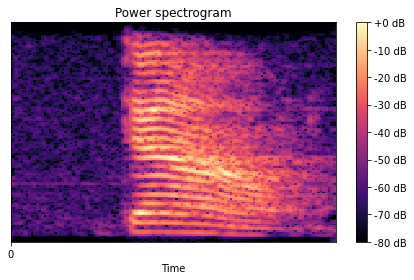

In [6]:
# 위에서 뽑았던 sample data를 spectrogram으로 변경
# data에 있는 자료를 빼서 spectrogram 리스트에 넣어줌(1차원 => 2차원)
data = speech_data["wav_vals"]
specs = []

for i in range(len(data)):
    spec = wav2spec(data[i]) # size를 변경한 wav를 하나씩 spec에 넣어줘
    specs.append(spec) # spec을 specs에 넣어줘
specs = np.array(specs) # specs를 np.array형식으로 변경해줘

print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",specs.shape)

# Spectrogram 시각화
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(specs[3], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [7]:
# 학습을 위한 데이터 분리
from sklearn.model_selection import train_test_split
# 기존 Waveform에서 8000개였던 갯수의 변경 필요
# sr = 8000 1초동안 재생되는 샘플의 갯수
xr = specs.shape[1]
yr = specs.shape[2]
# 데이터셋을 기존 speech_data["wav_vals"]에서 2차배열 데이터셋으로 변경
train_spec, test_spec, train_label, test_label = train_test_split(specs, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_spec = train_spec.reshape([-1, xr, yr, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, xr, yr, 1])
test_spec.shape

(5062, 130, 126, 1)

In [8]:
# 2. 학습을 위한 하이퍼파라미터 설정
batch_size = 32
max_epochs = 10

# 체크보인트 형성
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/spec'

In [9]:
# 3. 데이터셋 구성
def one_hot_label(spec, label):
    # tf.one_hot은 범주형 데이터에 사용하며
    # 주어진 리스트를 답지로 반환해준다. 답지는 12개로 한다.
    # ex) list[red, green, blue]일 경우
    # tf.one_hot([red,green,blue],3)은
    # [1,0,0],[0,1,0],[0,0,1]이 된다.
    label = tf.one_hot(label, depth=12)
    return spec, label

# tf.data.Dataset을 이용
#from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
# map과 batch를 이용한 데이터 전처리
#주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
#tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [10]:
# 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
# Conv2D 모델 구현
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
# MaxPool2D 2x2크기의 필터로 특징을 뽑아서 필터링한다.
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)
# Flatten : 다차원 배열을 1차원으로 만들어줌
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# BatchNormalization : 입력값 정규화
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [11]:
# Skip-Connection model 구현
input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [12]:
# 필요없어진 data 삭제
del speech_data
del data
del label_data
del specs
print("data 정리 완료")

data 정리 완료


- [Conv2D 내용](https://keras.io/ko/layers/convolutional/)  
- [MaxPool2D 내용](https://supermemi.tistory.com/16)  
- [Flatten내용](https://rfriend.tistory.com/349)  
- [Dens](https://wikidocs.net/32105)  
- [BatchNormalization, Drop out](https://buomsoo-kim.github.io/keras/2018/04/24/Easy-deep-learning-with-Keras-5.md/)



In [13]:
# 현재 라벨 : 12개의 단어 class
# multi-class classification 필요
# Categorical Cross-Entropy loss를 사용
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [14]:
# loss가 낮아지면 모델 파라미터를 저장하도록 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint('.\Conv2DM.h5',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
# 모델 훈련(30분정도 소요)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.7687
Epoch 00001: val_loss improved from inf to 0.37295, saving model to .\Conv2DM.h5
1423/1423 [==============================] - 235s 165ms/step - loss: 0.6911 - accuracy: 0.7687 - val_loss: 0.3730 - val_accuracy: 0.8859
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9257
Epoch 00002: val_loss improved from 0.37295 to 0.23215, saving model to .\Conv2DM.h5
1423/1423 [==============================] - 238s 167ms/step - loss: 0.2350 - accuracy: 0.9257 - val_loss: 0.2321 - val_accuracy: 0.9278
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9483
Epoch 00003: val_loss improved from 0.23215 to 0.19734, saving model to .\Conv2DM.h5
1423/1423 [==============================] - 230s 162ms/step - loss: 0.1613 - accuracy: 0.9483 - val_loss: 0.1973 - val_accuracy: 0.9381
Epoch 4/10
1423/1423 [======================

In [15]:
# 현재 라벨 : 12개의 단어 class
# multi-class classification 필요
# Categorical Cross-Entropy loss를 사용
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [16]:
# loss가 낮아지면 모델 파라미터를 저장하도록 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint('.\Skip.h5',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
# 모델 훈련(30분정도 소요)
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7703
Epoch 00001: val_loss improved from inf to 0.29577, saving model to .\Skip.h5
1423/1423 [==============================] - 258s 182ms/step - loss: 0.7071 - accuracy: 0.7703 - val_loss: 0.2958 - val_accuracy: 0.9078
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9328
Epoch 00002: val_loss improved from 0.29577 to 0.19865, saving model to .\Skip.h5
1423/1423 [==============================] - 245s 172ms/step - loss: 0.2116 - accuracy: 0.9328 - val_loss: 0.1987 - val_accuracy: 0.9377
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9564
Epoch 00003: val_loss improved from 0.19865 to 0.14341, saving model to .\Skip.h5
1423/1423 [==============================] - 243s 171ms/step - loss: 0.1381 - accuracy: 0.9564 - val_loss: 0.1434 - val_accuracy: 0.9551
Epoch 4/10
1423/1423 [==============================]

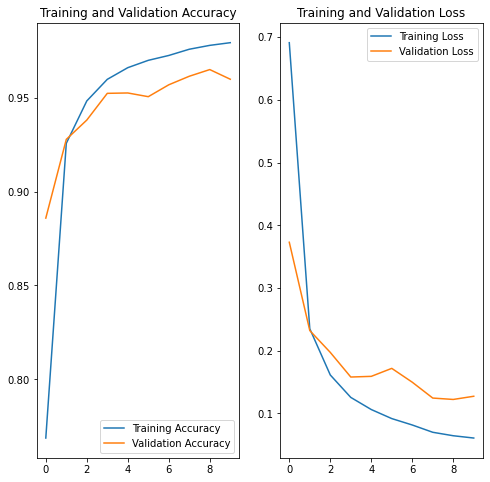

In [17]:
# 결과 시각화
# Conv2D 모델
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

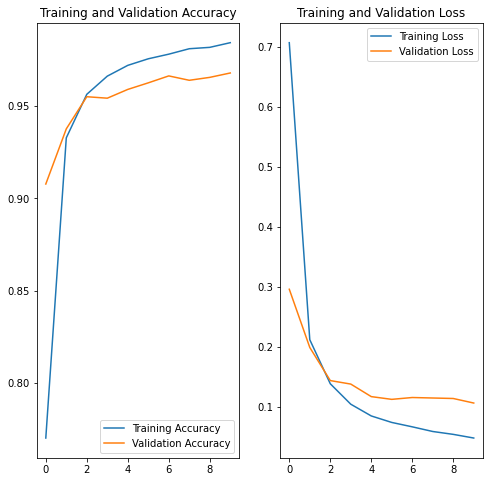

In [18]:
# 결과 시각화
# skip 모델
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model_spec.load_weights('.\Conv2DM.h5')
results = model_spec.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 33s 205ms/step - loss: 0.1222 - accuracy: 0.9650
loss value: 0.122
accuracy value: 96.5034%


In [20]:
model_spec_skip.load_weights('.\Skip.h5')
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 14s 90ms/step - loss: 0.1058 - accuracy: 0.9680
loss value: 0.106
accuracy value: 96.7997%


In [28]:
def spec2wav(wav):
    wav = wav.squeeze()
    D = np.abs(librosa.istft(wav))
    return D

In [25]:
# 예측값과 정답값이 일치하는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)


batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_spec = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  off


In [27]:
print(np.argmax(y_pred_spec))
print(test_label[batch_index][0])
if np.argmax(y_pred_spec) == test_label[batch_index][0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_spec)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_spec)]) + '(Incorrect!)')

7
7
y_pred: off(Correct!)


In [31]:
# 예측값과 정답값이 일치하는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)


batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_spec_skip = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))
ipd.Audio(spec2wav(batch_xs).reshape(8000,), rate=8000)

label :  on


In [33]:
print(np.argmax(y_pred_spec_skip))
print(test_label[batch_index][0])
if np.argmax(y_pred_spec_skip) == test_label[batch_index][0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_spec_skip)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_spec_skip)]) + '(Incorrect!)')

6
6
y_pred: on(Correct!)


***
### 결론
> **기존에 노드에서 1차원 wave를 2차원 spectrogram으로 변환하는 것을 활용하여 데이터셋을 구성하였다.  
> spectrogram은 x축이 시간 y축이 db로 되어있는 형태임을 확인하였다.  
> 1차적으로 1차원 wave를 2차원 spectrogram으로 변환하고 이를 Conv2D, Skip 모델을 활용하여 학습시켰다.**  

> ***학습결과  
> `Conv2D모델`   
> loss value: 0.122  
> accuracy value: 96.5034%***  
> 
> ***`Skip모델`  
> loss value: 0.106  
> accuracy value: 96.7997%***  

> **학습 결과는 위와 같은 결과를 확인하였으며, Skip모델이 Conv2D모델보다 근소한 차이로 정확도가 높은 것을 확인하였다.  
> 이를 토대로 각 모델의 예측값과 정답값이 일치하는지 확인하였으며, 2차원 spectrogram을 다시 1차원 wave로 변환하여 음성으로 확인하였다.  
> 음성으로 확인결과, 기존 1차원 wave를 학습시킨 모델에 비해 음성의 품질이 많이 떨어졌지만, 예측 결과는 일치하는 것으로 판단되었다.**
***
### 회고록
**생각보다 어어어어엄청 어려운 노드였다. 처음에 이론적인 부분들은 매우 흥미로웠으나, 이론을 후루룩 읽을때와 실제로 적용해서 진행해보는 것은 하늘과 땅차이였다.  
덕분에 이론과 실재간의 차이를 명확히 알 수 있었다.  
아직도 이론부분에서는 명확하게 이해가 되지는 않지만 이런 느낌이다 정도로 만족하고있다.  
조금더 깊게 공부해볼만한 분야라고 생각한다.  
추가적으로, 1차원 wave모델을 학습시켰을때에 비해 2차원 spectrogram을 다시 1차원 wave로 변환하여 음성을 재생했을때에 질이 너무 떨어졌다.  
이 이유에 대해서는 명확하게 확인하기 어려웠다.  
개인적으로는 이 분야에 대한 지식과, 모델의 설계 및 전체적인 흐름에 대한 이해도가 아직 부족해서라고 판단된다.  
앞으로 노드들을 더욱더 진행해 나가서 이해도가 높아지고 모델설계의 질이 높아지면 이러한 부분들을 조금이라도 줄일 수 있으리라 기대해본다.**
